<a href="https://colab.research.google.com/github/davorrunje/websummercamp2025/blob/main/01_Introduction_to_AG2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to AG2

## Supported LLM Providers

Your agents deserve options! AG2 plays nicely with an impressive lineup of model providers:

- Cloud Models: OpenAI, Anthropic, Google (Gemini), Amazon (Bedrock), Mistral AI, Cerebras, Together AI, and Groq
- Local Models: Ollama, LiteLLM, and LM Studio

So whether you want to tap into cloud-based intelligence or keep things running on your local machine, AG2 has got you covered. You can find more information about the supported models in the [AG2 Models documentation](https://docs.ag2.ai/latest/docs/user-guide/models/amazon-bedrock/).

We will be using OpenAI for this workshop. Please visit the OpenAI website and create as API key:

https://platform.openai.com/api-keys




Next, store the key in Secret section in your Colab as shown in the screeshot below:

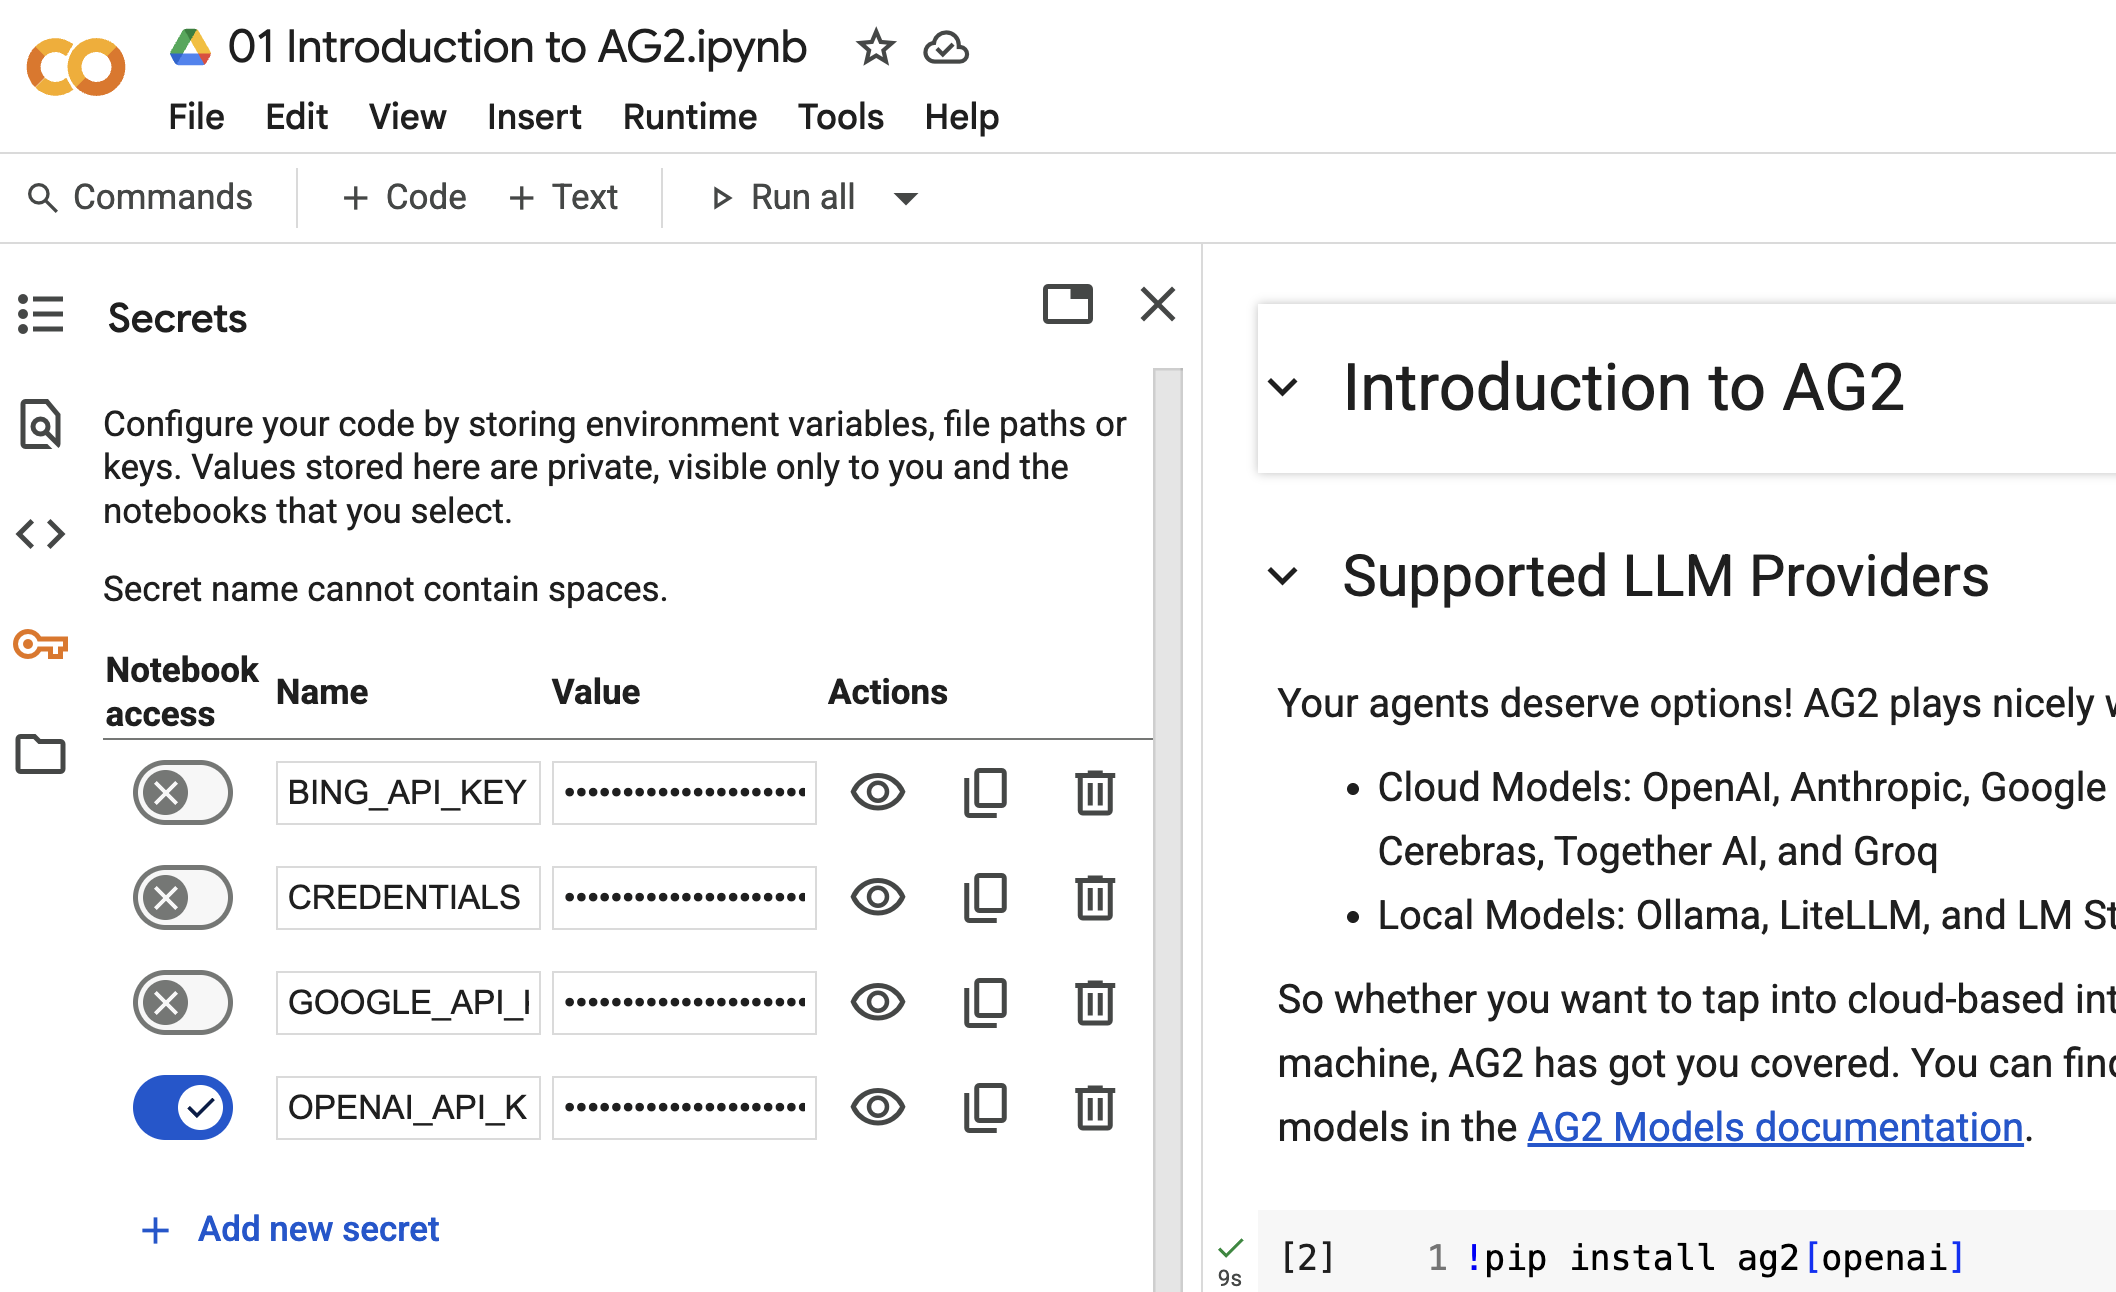

Test can you access your secret API key:

In [12]:
from google.colab import userdata
api_key = userdata.get('OPENAI_API_KEY')
assert api_key.startswith("sk-")

## Install AG2 Python package

Depending on the LLM you wish to use, install AG2 package with optional target such as `openai` or `gemini`.

In [13]:
!pip install ag2[openai]

## Creating and using an LLM Configuration

Once you have installed AG2 with your preferred LLM provider, we need to create the LLM configuration object with the API type, model, and key if necessary.

In [14]:
import os
from autogen import LLMConfig

llm_config = LLMConfig(
    api_type="openai",     # The provider
    model="gpt-4o-mini",   # The specific model
    api_key=api_key,       # Authentication
)

llm_config

LLMConfig(config_list=[{'api_type': 'openai', 'model': 'gpt-4o-mini', 'api_key': '**********', 'tags': []}])

Use context manager to create agents using the configuration:

In [15]:
from autogen import ConversableAgent

with llm_config:
    finance_agent = ConversableAgent(
        name="finance_agent",
        system_message="You are a financial compliance assistant",
    )

    analysis_agent = ConversableAgent(
        name="analysis_agent",
        system_message="You analyze financial data for anomalies",
    )

print(finance_agent.llm_config)
print(analysis_agent.llm_config)

LLMConfig(config_list=[{'api_type': 'openai', 'model': 'gpt-4o-mini', 'api_key': '**********', 'tags': []}])
LLMConfig(config_list=[{'api_type': 'openai', 'model': 'gpt-4o-mini', 'api_key': '**********', 'tags': []}])


We can test our LLM config and agent by running it with a simple question:

In [16]:
%%time

# Run the agent
response = finance_agent.run(
    message="What's up with Bitcoin and stuff?",
    max_turns=1
)

CPU times: user 1.59 ms, sys: 0 ns, total: 1.59 ms
Wall time: 1.82 ms


In [17]:
%%time

# Process the workflow
response.process()

user (to finance_agent):

What's up with Bitcoin and stuff?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
finance_agent (to user):

As of October 2023, Bitcoin continues to be a significant player in the cryptocurrency market and has experienced various fluctuations in price and regulatory scrutiny. Here are some key points:

1. **Price Volatility**: Bitcoin's price is known for its volatility, experiencing sharp rises and falls influenced by market sentiment, regulatory news, and macroeconomic factors.

2. **Regulatory Environment**: Various countries continue to develop regulations for cryptocurrencies. Some nations are becoming more supportive, while others are imposing strict regulations to control the market and prevent illicit activities.

3. **Adoption and Use Cases**: Bitcoin is increasingly being used beyond speculative investment. Some businesses accept it as payment, and discussions around Bitcoin as a potenti

## Human in the Loop

Human in the Loop (HITL) is a powerful pattern that enables your AG2 agents to collaborate with humans during their workflow. Instead of making all decisions independently, agents can check with human operators at critical decision points, combining AI efficiency with human judgment.

### An Analogy for HITL
Think of Human in the Loop like a hospital treatment system:

- Doctors (AI agents) examine patients, run tests, and prepare treatment plans
- For serious or unusual conditions, they consult with senior specialists (humans) before proceeding
- The specialist provides final approval for critical treatments or unusual cases
- The doctor then handles all the details once approval is given
- This partnership combines the doctor's efficiency with the specialist's judgment for important decisions
- This approach ensures routine cases are handled quickly while critical decisions receive proper oversight.

### When to Use HITL
Human in the Loop is particularly valuable when:

- Decisions require nuanced judgment (e.g., financial compliance, legal matters)
- Errors could have significant consequences (e.g., financial transactions, safety-critical systems)
- The process benefits from subjective input (e.g., content approval, design choices)
- Regulatory requirements mandate human oversight (e.g., financial services, healthcare)

### Example

Creating agents

In [24]:
from autogen import UserProxyAgent

# Define the system message for our finance bot
finance_system_message = """
You are a financial compliance assistant. You will be given a set of transaction descriptions.
For each transaction:
- If it seems suspicious (e.g., amount > $10,000, vendor is unusual, memo is vague), ask the human agent for approval.
- Otherwise, approve it automatically.
Provide the full set of transactions to approve at one time.
If the human gives a general approval, it applies to all transactions requiring approval.
When all transactions are processed, summarize the results and say "You can type exit to finish".
"""

# Create the finance agent with LLM intelligence
with llm_config:
    finance_bot = ConversableAgent(
        name="finance_bot",
        system_message=finance_system_message,
    )

# Create the human agent for oversight (no need for LLM config here)
human = UserProxyAgent(
    name="human",
)

In [32]:
import random

# Generate sample transactions - this creates different transactions each time you run
VENDORS = ["Staples", "Acme Corp", "CyberSins Ltd", "Initech", "Globex", "Unicorn LLC"]
MEMOS = ["Quarterly supplies", "Confidential", "NDA services", "Routine payment", "Urgent request", "Reimbursement"]

def generate_transaction():
    amount = random.choice([500, 1500, 9999, 12000, 23000, 4000])
    vendor = random.choice(VENDORS)
    memo = random.choice(MEMOS)
    return f"Transaction: ${amount} to {vendor}. Memo: {memo}."

# Generate 5 random transactions
transactions = [generate_transaction() for _ in range(5)]

transactions

['Transaction: $500 to Staples. Memo: Routine payment.',
 'Transaction: $12000 to Globex. Memo: Quarterly supplies.',
 'Transaction: $500 to Staples. Memo: Reimbursement.',
 'Transaction: $23000 to Globex. Memo: Urgent request.',
 'Transaction: $1500 to Initech. Memo: Urgent request.']

In [33]:
# Format the initial message
initial_prompt = (
    "Please process the following transactions one at a time:\n\n" +
    "\n".join([f"{i+1}. {tx}" for i, tx in enumerate(transactions)])
)

# Start the conversation from the human agent
response = human.run(
    recipient=finance_bot,
    message=initial_prompt,
)

# Display the response
response.process()

human (to finance_bot):

Please process the following transactions one at a time:

1. Transaction: $500 to Staples. Memo: Routine payment.
2. Transaction: $12000 to Globex. Memo: Quarterly supplies.
3. Transaction: $500 to Staples. Memo: Reimbursement.
4. Transaction: $23000 to Globex. Memo: Urgent request.
5. Transaction: $1500 to Initech. Memo: Urgent request.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
finance_bot (to human):

Let's take a look at the transactions one by one:

1. Transaction: $500 to Staples. Memo: Routine payment.
   - This transaction is not suspicious. **Approved.**

2. Transaction: $12000 to Globex. Memo: Quarterly supplies.
   - This transaction is suspicious due to the amount over $10,000. **Requires human approval.**

3. Transaction: $500 to Staples. Memo: Reimbursement.
   - This transaction is not suspicious. **Approved.**

4. Transaction: $23000 to Globex. Memo: Urgent request.
   - This t